<a href="https://colab.research.google.com/github/kailliang/Data-Science-with-Machine-Learning-Models/blob/main/Feature_Correlation_and_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

random_state = 42
# Read data
data = pd.read_csv('/content/drive/MyDrive/job_data.csv')
date_columns = ['reported_date', 'target_finish', 'actual_finish']
# Parse date-time columns
for col in ['reported_date', 'target_finish', 'actual_finish']:
    data[col] = pd.to_datetime(data[col], dayfirst=True, errors='coerce')

# Drop rows with invalid datetime values
data = data.dropna(subset=date_columns)
# Create "on_time" column
data['on_time'] = (data['actual_finish'] <= data['target_finish']).astype(int)

# Create "job_duration" column
data['job_duration'] = (data['target_finish'] - data['reported_date']).dt.total_seconds() / 3600

# Handle missing data
data = data.dropna()

# Create time features
data['reported_hour'] = data['reported_date'].dt.hour
data['reported_day_of_week'] = data['reported_date'].dt.dayofweek
data['reported_month'] = data['reported_date'].dt.month
data['reported_year'] = data['reported_date'].dt.year

data['target_hour'] = data['target_finish'].dt.hour
data['target_day_of_week'] = data['target_finish'].dt.dayofweek
data['target_month'] = data['target_finish'].dt.month
data['target_year'] = data['target_finish'].dt.year

# Encode categorical features
le = LabelEncoder()
data['location_type'] = le.fit_transform(data['location_type'])
data['raised_within_workhours'] = le.fit_transform(data['raised_within_workhours'])

# Select features and target
features = data[['priority', 'emergency', 'location_type', 'raised_within_workhours',
                 'reported_hour', 'reported_day_of_week', 'reported_month', 
                 'reported_year', 'target_hour', 'target_day_of_week', 'target_month', 
                 'target_year']]

target = data['on_time']

# Handle Class Imbalance with SMOTE
sm = SMOTE(random_state=random_state)
features_res, target_res = sm.fit_resample(features, target)

# Define K-fold cross validation
kf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

# Initialize lists to hold the results for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
feature_importances = []

# Initialize the model
model = LGBMClassifier()
# model = LGBMClassifier(**best_params)

# Perform K-fold cross validation
for train_index, test_index in kf.split(features_res, target_res):
    X_train, X_test = features_res.iloc[train_index], features_res.iloc[test_index]
    y_train, y_test = target_res.iloc[train_index], target_res.iloc[test_index]
    
    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # probabilities for the positive outcome
    
    # Compute metrics and append to the results lists
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_proba))

    # Append feature importances for the current fold
    feature_importances.append(model.feature_importances_)

# Print cross validation scores
print("Accuracy: %.2f%%" % (np.mean(accuracies)*100))
print("Precision: %.2f%%" % (np.mean(precisions)*100))
print("Recall: %.2f%%" % (np.mean(recalls)*100))
print("F1 Score: %.2f%%" % (np.mean(f1_scores)*100))
print("ROC AUC Score: %.2f%%" % (np.mean(roc_aucs)*100))
print("\n")
# Compute mean feature importances and print with corresponding feature names
mean_feature_importances = np.mean(feature_importances, axis=0)



<ipython-input-2-9dc7056d1068>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['on_time'] = (data['actual_finish'] <= data['target_finish']).astype(int)
<ipython-input-2-9dc7056d1068>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['job_duration'] = (data['target_finish'] - data['reported_date']).dt.total_seconds() / 3600


Accuracy: 77.26%
Precision: 78.54%
Recall: 75.45%
F1 Score: 76.88%
ROC AUC Score: 83.96%




In [3]:
# Your results
feature_importances = list(zip(features_res.columns, mean_feature_importances))

# Calculate the sum of all feature importances
total = sum([importance for _, importance in feature_importances])

# Normalize the feature importances and print
normalized_importances = [(feature, round((importance / total) * 100, 2)) for feature, importance in feature_importances]
for feature, importance in normalized_importances:
    print(f"{feature}: {importance}%")


priority: 9.2%
emergency: 1.76%
location_type: 0.0%
raised_within_workhours: 1.17%
reported_hour: 17.69%
reported_day_of_week: 10.17%
reported_month: 14.29%
reported_year: 6.13%
target_hour: 14.47%
target_day_of_week: 11.57%
target_month: 11.95%
target_year: 1.6%


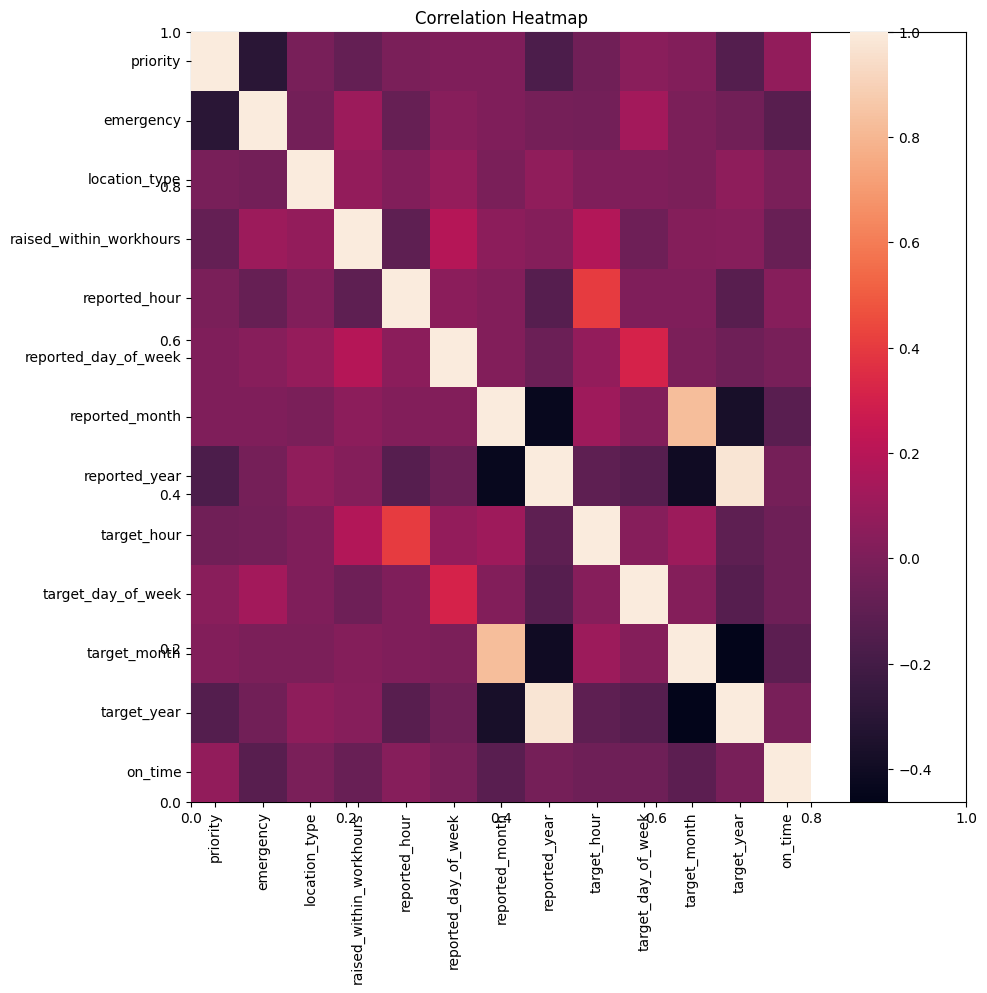

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt
def getcorr_fig(corr):
    plt.subplots(figsize=(10,10))
    ax = plt.axes()
    ax.set_title("Correlation Heatmap")

    sns.heatmap(corr, 
                xticklabels=list(corr.columns),
                yticklabels=list(corr.columns))

corr=data[['priority', 'emergency', 'location_type', 'raised_within_workhours',
                 'reported_hour', 'reported_day_of_week', 'reported_month', 
                 'reported_year', 'target_hour', 'target_day_of_week', 'target_month', 
                 'target_year', 'on_time']].corr()

getcorr_fig(corr)